In [133]:
import numpy as np
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import copy
import random

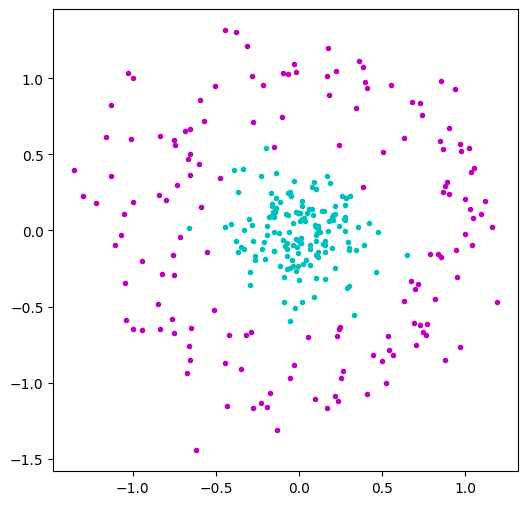

In [134]:
X,y = make_circles(n_samples = 300, noise=0.2, factor=0.1, random_state=43)
n,d = X.shape
plt.figure(1,figsize=[6,6])
plt.plot(X[:,0][np.where(y==1)],X[:,1][np.where(y==1)],'.c')
plt.plot(X[:,0][np.where(y==0)],X[:,1][np.where(y==0)],'.m')

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0;">

The dataset generated is non linearly separable and the class are overlapping. We created it using make_circle with some bias to make the class overlapp.  
Because the boundary function of this dataset is circular, a single linear classifier can't model it effectively.  
To solve this type of problem we will need to combine several linear models.

In [135]:
def sigmoid(x):
    '''
    Sigmoid activation function
    
    :param x: Input value or array
    :return: Sigmoid of the input
    '''
    res = 1 / (1 + np.exp(-x))
    return res

## Exercice 1 : Network creation

In [136]:
class InputUnit:
    '''
    Unit representing an input feature in the neural network.

    Attributes:
        data: A numpy array representing one column of the input matrix X
        n: Size of the dataset
        k: Layer index (initialized to 0 for input layer)
        z: Output of the unit (initialized to 0)
    '''
    def __init__(self,data):
        '''
        Initialization of the InputUnit class.
        
        :param self: Object instance
        :param data: taking one column of matrix X
        '''
        self.data = data #one column of matrix X
        self.n = data.shape[0] #dataset size
        self.k = 0 #layer number
        self.z = 0 #unit output
    
    def plug(self, target):
        '''
        Connect this input unit to a neural unit.

        :param self: Object instance
        :param target: NeuralUnit instance to connect to

        '''
        target.preceding.append(self)
        target.npr += 1 #increment the number of preceding units of the target unit
    
    def forward(self, i):
        '''
        Forward pass for the input unit.
        
        :param self: Object instance
        :param i: index of the example to perform forward pass on
        :return: output value for the given example
        '''
        self.z = self.data[i]
        return self.data[i]

    def __str__(self):
        return f"Input : [Layer: {self.k}] | shape: {self.data.shape} | output = {self.z}"

In [ ]:
class NeuralUnit:
    '''
    Unit representing a neural unit in the network.

    Attributes:
        u: Unit number in its layer
        preceding: List of preceding units
        npr: Number of preceding units
        following: List of following units
        nfo: Number of following units
        k: Layer index
        w: Weights of the unit
        b: Intercept of the unit
        z: Output of the unit
    '''
    #Constructor
    def __init__(self,k,u):
        '''
        Initialization of the InputUnit class.
        
        :param self: Object instance
        :param k: layer index
        :param u: unit number
        '''
        self.u = u #unit number
        self.preceding = [] #list of preceding neurons
        self.npr = 0 #length of list preceding
        self.following = [] #list of following neurons
        self.nfo = 0 #length of list following
        self.k = k #layer number
        self.w = 0 #unit weights
        self.b = 0 #unit intercept
        self.z = 0 #unit output

    def plug(self, target):
        '''
        Connect this neural unit as the preceding unit of another neural unit/loss unit.
        
        :param self: Object instance
        :param target: target neural unit/loss unit to connect to
        '''
        self.following.append(target)
        self.nfo += 1
        target.preceding.append(self)
        target.npr += 1

    def reset_params(self):
        '''
        Randomly initialize the weights and bias of the neural unit.
        
        :param self: Object instance
        '''
        self.w = np.random.randn(self.npr)
        self.b = np.random.randn()

    def forward(self, i):
        '''
        Forward pass for the neural unit.
        
        :param self: Object instance
        :param i: index of the example to perform forward pass on
        :return: output value for the given example
        '''
        
        z_in = np.zeros_like(self.w)
        for index, unit in enumerate(self.preceding):
            z_in[index] = unit.forward(i)
        self.z = sigmoid(np.dot(self.w, z_in.T) + self.b)
        return self.z
    
    def backprop(self, i, deltas):
        '''
        Backpropagation for the neural unit.
        
        :param self: Object instance
        :param i: index of the example 
        :param deltas: array of delta values from the following layer
        '''
        # delta ones
        self.delta = np.zeros(self.w.shape)

        for v, unit in enumerate(self.preceding):
            derivative = self.z * (1 - self.z) * self.w[v]
            ## deltas[self.u-1] because the first u = 1, but the array start at 0
            self.delta[v] = derivative * deltas[self.u-1]

        # parameter ones
        self.w_grad = np.zeros(self.w.shape)
        self.b_grad = 0
        for v, unit in enumerate(self.preceding):
            w_derivative = self.z * (1 - self.z) * self.preceding[v].z
            self.w_grad[v] = w_derivative * deltas[self.u-1]

        self.b_grad = self.z * (1 - self.z) * deltas[self.u-1]

    def __str__(self):
        return f"Neural: [Layer: {self.k} | Unit: {self.u}] | Input size: {self.npr} | Output size: {self.nfo} | Weights: {self.w} | output = {self.z}"

In [138]:
class Loss:
    '''
    Unit representing the loss unit

    Attributes:
        preceding: List of preceding units
        npr: Number of preceding units
        y: Array of labels of the training data
        k: Layer index
    '''
    #Constructor
    def __init__(self,y,k):
        '''
        Initialization of the Loss class.
        
        :param self: Object instance
        :param y: array of labels of the training data
        :param k: layer index
        '''
        self.preceding = [] #list of preceding neurons
        self.npr = 0 #length of list preceding
        self.y = y #array of class labels of the training data
        self.k = k #layer index
        
        self.delta = np.zeros((1,)) # added for the backpropagation


    # Using here the binary cross entropy
    def forward(self, i):
        '''
        Forward pass for the loss unit.
        
        :param self: Object instance
        :param i: index of the example to perform forward pass on
        :return: loss value of the prediction for the given example
        '''
        z_in = self.preceding[0].forward(i)
        if self.y[i] == 0:
            loss_i = -np.log(1-z_in)
        else : 
            loss_i = -np.log(z_in)
            
        return loss_i
    
    def backprop(self, i):
        '''
        Backpropagation for the loss unit.
            Compute the derivative of the loss with respect to the output of the preceding unit.
            Store the result in self.delta[0]
        :param self: Object instance
        :param i: index of the example to perform backpropagation on
        '''
        deriv = 0
        if self.y[i] == 0:
            deriv = 1/(1-(self.preceding[0].z))
        else : 
            deriv = -1/(self.preceding[0].z)
        self.delta[0] = deriv

    def __str__(self):
        return f"Loss : [Layer: {self.k}] | Input = {self.npr}"

In [ ]:
# Fully connected, so every unit in the layer k are connected to every unit of the layer k+1.
class MLP:
    '''
    Multilayer Layer Perceptron class, representing the neural network.
    
    Attributes:
        archi: Architecture of the neural network
        X: Input data matrix
        n: Number of samples in the dataset
        y: Labels of the training data
        K: Number of layers (including input layer but omitting loss layer)
        net: Array of layers, each layer being an array of units (in order of layer)
    '''
    #Constructor
    def __init__(self,X,y,archi):
        '''
        Initialization of the MLP class.
            Create the network according to the architecture (archi) given in parameter.
        
        :param self: Object instance
        :param X: training data
        :param y: labels of the training data
        :param archi: architecture of the neural network
        '''
        self.archi = archi
        self.X = X
        self.n = X.shape[0]
        self.y = y
        self.K = len(archi) #number of layers (including input layer but omitting loss layer)
        
        # Creating the network
        net = []

        for layer, nb_unit in enumerate(archi):
            units_layer = []
            for i in range(1, nb_unit+1):
                if layer == 0:
                    units_layer.append(InputUnit(X[:,i-1]))
                else :
                    nu = NeuralUnit(layer, i)
                    # Plugging 
                    for unit in net[-1]:
                        unit.plug(nu)
                    nu.reset_params()
                    units_layer.append(nu)
            # Adding units of this layer to the net
            net.append(units_layer)
        l = Loss(y, len(archi))
        for unit in net[-1]:
            unit.plug(l)
        net.append([l])
        # Adding to the class
        self.net = net

    def forward(self, i):
        '''
        Forward pass through the network.
        
        :param self: Object instance
        :param i: index of the example to perform forward pass on
        :return: loss value of the prediction for the given example
        '''
        return self.net[-1][-1].forward(i)
        
    def backprop(self, i):
        '''
        Backpropagation through the network.
        
        :param self: Object instance
        :param i: index of the example to perform backpropagation on
        '''
        
        for k in range(self.K,0, -1): # loop from the last layer to the first one
            if k == self.K: # loss layer
                    self.net[k][0].backprop(i) 
                    deltas = self.net[k][0].delta
            else :
                for u, unit in enumerate(self.net[k]): # loop over the units of the layer
                    deltas_new = np.zeros((self.net[k][0].npr,)) 
                    self.net[k][u].backprop(i,deltas)
                    deltas_new += self.net[k][u].delta
                deltas = deltas_new # updating deltas for the next layer

    def update(self, eta):
        '''
        Use the computed gradients to update the weights and biases of the network.
        
        :param self: Object instance
        :param eta: Learning rate
        '''
        for layer in range(1, len(self.archi)):
            for unit in self.net[layer]:
                unit.w = unit.w - eta * unit.w_grad # update weights
                unit.b = unit.b - eta * unit.b_grad # update bias
    
    def train(self, epochs, eta, print_loss=False):
        '''
        Train the neural network using the training data.
        
        :param self: Object instance
        :param epochs: number of training epochs
        :param eta: learning rate
        :param print_loss: if you want to print or not the loss during training
        '''
        loss = []
        for epoch in range(epochs):
            for i in range(self.n):
                self.forward(i)
                self.backprop(i)
                self.update(eta)
            if print_loss:
                total_loss = 0
                for i in range(self.n):
                    total_loss += self.forward(i)
                avg_loss = total_loss / self.n
                loss.append(avg_loss)

        # Plot loss
        if print_loss:
            plt.figure()
            plt.plot(range(1, epochs+1), loss)
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title('Training loss over epochs')
            plt.show()


    # Predict a value of i, is equal of a forward propagation without the lost layer (last one).
    def predict(self, i):
        '''
        Predict the output for a given index
        
        :param self: Object instance
        :param i: index of the input example
        :return: predicted output value
        '''
        self.net[-2][0].forward(i)
        return self.net[-2][0].z
    
    def __str__(self):
        res = "MLP Network:\n"
        for layer in self.net:
            for unit in layer:
                res += str(unit) + "\n"
        return res

### Ex 1.1

In [140]:
# Creation of the d=2 input units

x1 = InputUnit(X[:,0])
x2 = InputUnit(X[:,1])
print(x1)
print(x2)

Input : [Layer: 0] | shape: (300,) | output = 0
Input : [Layer: 0] | shape: (300,) | output = 0


<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0;">

The input unit take as parameter a column of our input matrix.  
So if $X \in M_{m,n}$ with $X$ the input matrix, then the model has $n$ input units, one for each feature.  
In our case the input unit are the first layer so we define by default the layer at 0.

### Ex 1.2

In [141]:
# Creating 2 layers made of 2 and 1 unit.

## Neural unit 1 and 2 of the layer 1
nu_1_1 = NeuralUnit(1, 1)
nu_1_2 = NeuralUnit(1,2)

## Neural unit 1 of the layer 2
nu_2_1 = NeuralUnit(2,1)

print(nu_1_1)

Neural: [Layer: 1 | Unit: 1] | Input size: 0 | Output size: 0 | Weights: 0 | output = 0


<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0;">

The neural unit take as parameter the layer and the position of the unit.  
Ex : $u_{1,2}$ is the second unit of the layer 1. 

### Ex 1.3

In [142]:
# Creating instance of Loss unit

l_3 = Loss(y,3)
print(l_3)

Loss : [Layer: 3] | Input = 0


<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0;">

The loss unit take as parameter the labels of our training set *(needed to compute the loss)* and the layer.
There is only one loss unit in our model so we don't need to specify the number of the unit, only the layer.

### Ex 1.4 : Adding the plug method

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0;"> 

**Input layer** : 
The plug function take one unit $u$ of the next layer as a parameter and add to the list of preceding of $u$ itself.

**Neural Unit** :
The plug function for the neural unit work almost the same, but can each time you add your unit $u$ in the list of preceding unit of $v$, you add $v$ in the list of following of $u$.  
In addition, this method can take as an input a loss unit or a neural unit.

This plug function will allow us to go through the network from the last unit to first unit, which is useful for both forward and backward propagation.

### Ex 1.5 : Creating MLP class and the network

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0;"> 

In the initialization of the class, we have to setup the network described in the archi parameter.  
We are in a fully connected network, so each unit of the layer $k-1$ must be plug to each unit of the layer $k$.  

For this we iterate over each layer, instantiating and plugging the units, using reset_params to randomly initialize the weights of each neural units.   
Finally, we connect all the unit of the last layer to a lost unit, representing the end of the network.

### Representation of the MLP network

In [143]:
mlp = MLP(X,y, [2,2,1])
print(mlp)

MLP Network:
Input : [Layer: 0] | shape: (300,) | output = 0
Input : [Layer: 0] | shape: (300,) | output = 0
Neural: [Layer: 1 | Unit: 1] | Input size: 2 | Output size: 1 | Weights: [-1.83658324  0.56446424] | output = 0
Neural: [Layer: 1 | Unit: 2] | Input size: 2 | Output size: 1 | Weights: [0.47319325 0.6591906 ] | output = 0
Neural: [Layer: 2 | Unit: 1] | Input size: 2 | Output size: 1 | Weights: [1.07098519 0.09641648] | output = 0
Loss : [Layer: 3] | Input = 1



## Exercise n°2 : Forward pass

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0;"> 

The forward propagation is the sigmoid applied on the linear combinaison of the weigths of our units and the inputs.  

To compute the forward pass of a unit, we need to compute the forward pass of his preceding units represented by the array $z_{i,k-1}$.
$$ z_{i,k,u} = \sigma(w_{k,u} . z_{i,k-1} + b_{k, u})$$

So to compute the forward pass of the loss, you have to compute the forward pass of each unit through the whole network. 

The forward pass of the Loss, use the $z$ output of the only unit of the last layer which represent the probability of having x labelled 1 and compute his loss.  
The loss use is the **binary-cross entropy loss**, between 0 and $\infty$, 0 representing x correctly labelled. 
The bigger the loss is, the worst the prediction are.

Finally, implementing the forward pass of the MLP consist only in calling the forward method of the Loss unit which ill call the forward method of the previous layers.

In [144]:
# # Quick verification
np.random.seed(42)

i = 4
print(f"Neural unit before forward : z = {mlp.net[1][0].z}")
mlp.net[1][0].forward(i)
print(f"Neural unit after forward : z = {mlp.net[1][0].z}")
print("-------- Details of the computation --------")
print(f"Input unit 1 z{i} = {mlp.net[0][0].z}")
print(f"Input unit 2 z{i} = {mlp.net[0][1].z}")
print(" ")
print(f"Neural unit bias b = {mlp.net[1][0].b}")
print(f"Neural unit weights = {mlp.net[1][0].w}")

Neural unit before forward : z = 0
Neural unit after forward : z = 0.7489479361904154
-------- Details of the computation --------
Input unit 1 z4 = -0.4756343043716168
Input unit 2 z4 = 0.34362932860099843
 
Neural unit bias b = 0.025500668081348373
Neural unit weights = [-1.83658324  0.56446424]


### Testing Loss's forward method

In [145]:
mlp = MLP(X,y, [2,2,1])
np.random.seed(42)
indices = np.random.randint(0, X.shape[0], size=10)
for i in indices:
    li = mlp.net[-1][-1].forward(i)
    print(f"Label of i={i} : {y[i]}, Prediction of the last neural unit : {mlp.net[-2][-1].z} Loss : {li}")

Label of i=102 : 0, Prediction of the last neural unit : 0.6002018976251592 Loss : 0.9167956033632177
Label of i=270 : 1, Prediction of the last neural unit : 0.7101069638430502 Loss : 0.34233966699377405
Label of i=106 : 1, Prediction of the last neural unit : 0.7226039272283951 Loss : 0.3248940254253601
Label of i=71 : 1, Prediction of the last neural unit : 0.6959906420505586 Loss : 0.36241906406776386
Label of i=188 : 1, Prediction of the last neural unit : 0.7419327788467961 Loss : 0.29849663446478725
Label of i=20 : 0, Prediction of the last neural unit : 0.7282990802674301 Loss : 1.3030533774522521
Label of i=102 : 0, Prediction of the last neural unit : 0.6002018976251592 Loss : 0.9167956033632177
Label of i=121 : 1, Prediction of the last neural unit : 0.727479816442044 Loss : 0.31816902404363
Label of i=214 : 1, Prediction of the last neural unit : 0.7282435598400121 Loss : 0.3171197265184452
Label of i=87 : 1, Prediction of the last neural unit : 0.7019223452088452 Loss : 0.

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0;"> 

As we can see, the closer the prediction is to 1 when the label is 0, the higher the loss becomes.  
In addition, we see that the forward pass tends to produce high and very close probabilities in many cases, regardless of the labels of X.

This is because the quality of the predictions is currently completely random (depending on the initialization, the probabilities could also often be low).  
The weights are initialized randomly, and no backpropagation has been performed, so the network has not learned anything from the inputs yet.

## Exercice 3

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0;"> 

Because the backpropagation is using the computation from the previous layers, it is mandatory to compute the backpropagation after the forward propagation. 
For the backpropagation we compute the derivative of the loss function in terms of every parameter of the model *(every weight and bias)*. 

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0;"> 

### 3.1 : Backpropagation of the Loss 
The first step of a backprop is to compute the derivative of the loss in regard of the output of the neural unit of the last layer.  
For this we compute the derivative of the **binary cross-entropy** *(the loss compute in the loss unit)* and we store the derivative to use it after.

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0;"> 

### 3.2 : Backpropagation of the Neural unit 
Same as the Loss unit, we want to compute after the backprop of the **Neural unit** how much the weight impact the loss and how much we have to change them.  
For **Neural unit**, we have two derivatives to compute : 
- the one usefull for the delta $\delta^{(k)}_v$ with $v$ each vector of the layer $k$.
- the one usefull for the parameter which are use to modify the weight and the bias of each neural units acording to their importance in the loss.

**For the delta ones**  
Each unit $u$ from the layer $k$, compute the part of influence of each $v$ from the layer $k-1$ in the gradient of the loss $\delta^{k+1}$.
$$\frac{dz_u}{dz_{in,v}} \times \delta_u^{k+1}$$

With $\frac{dz_u}{dz_{in,v}}$, given by $z_u(1-z_u)w^{(k)}_{v,u}$  *(derivative of th sigmoid)*.

After this, you can sum all these derivative to find the $\delta^{(k)}_u$

**For the delta ones**  
After this we can compute the derivate usefull for the update of the weights and the intercept and save them.  
The bias gradient is equivalent to the weight gradient with an input fixed to one.

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0;"> 

### 3.3 : Backpropagation of the MLP class
After implementing all the backprop method in all the unit *(except Input because there is no gradient to compute)*, we implement the method in the **MLP** class.  
We start by computing the $\delta$ of the last layer *(loss)* and save it's delta to compute the delta of the previous layer.  
Then we go through all the unit of all the layer and we compute the delta derivatives of the layer $k$ using the delta of the next layer $k+1$.

Once all deltas are computed, the gradients of the loss in regard to each weight/intercept are calculated and stored to be used later for updating the parameters.

### Trying to launch the backpropagation of the MLP

In [146]:
i = 0
archi = [d,10,1]
mlp = MLP(X,y,archi)
mlp.forward(i)
mlp.backprop(i)
epsi=1e-6
mlp2 = copy.deepcopy(mlp)
mlp2.net[1][0].w[0] = mlp.net[1][0].w[0] + epsi
print("numerical␣derivative␣is:",(mlp2.forward(i) - mlp.forward(i))/epsi)
print("computed␣derivative␣is:",mlp.net[1][0].w_grad[0])

numerical␣derivative␣is: 0.03542131166156537
computed␣derivative␣is: 0.0354213112713846


<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0;"> 

As we can see, the numerical derivative is really close to the computed derivative, the difference being only of the order $10^{-5}$.   
We found the derivate compute with epsilon is almost equal to the gradient of $w^{(1)}_1$ compute in the backprop so 
$$
    \frac{\partial l}{\partial w^{(1)}_1} \approx \frac{l(w^{(1)}_1+\epsilon) - l(w^{(1)}_1)}{\epsilon}
$$.

##  Exercice 4

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0;"> 

## 4.1 
In the method update of the class, we use the gradient of the loss with respect to the weight and the gradient of the loss with respect to the bias previously computed in the backprop to update our weight.  
To update our **weights** and **bias** we substract their corresponding gradient to our weight and our bias.  
We substract the gradient because, $-\nabla l(w)$ give us the direction of the steepest decrease of the loss function.

We use a learning rate $\eta$ to control the intensity of the parameter updates *(same for the bias)*.   
A too large learning rate can make us avoid the minimum, while a too small $\eta$ can slow down the convergence or cause our optimization to get stuck in flat region of the loss.
$$w = w - \eta \nabla l(w)$$

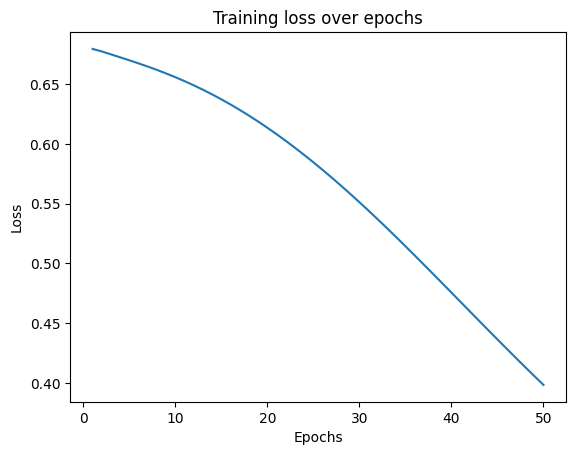

In [147]:
# Let's show the training process
mlp.train(50,0.01, print_loss=True)

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0;"> 

As observed, the loss decreases as training progresses.

In [148]:
# Test the predict method
indices = np.random.randint(0, X.shape[0], size=10)
for i in indices:
    li = mlp.net[-1][-1].forward(i)
    print(f"Label of i={i} : {y[i]}, Prediction of the last neural unit : {mlp.predict(i)}")

Label of i=251 : 0, Prediction of the last neural unit : 0.3594749913845768
Label of i=189 : 1, Prediction of the last neural unit : 0.7341043516219672
Label of i=295 : 0, Prediction of the last neural unit : 0.2563107956597722
Label of i=212 : 0, Prediction of the last neural unit : 0.23519374489063308
Label of i=207 : 0, Prediction of the last neural unit : 0.266266981974707
Label of i=236 : 0, Prediction of the last neural unit : 0.48315798870813853
Label of i=52 : 0, Prediction of the last neural unit : 0.1710152927584762
Label of i=279 : 0, Prediction of the last neural unit : 0.4865845349033419
Label of i=216 : 1, Prediction of the last neural unit : 0.72371260488854
Label of i=251 : 0, Prediction of the last neural unit : 0.3594749913845768


<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0;"> 

## 4.3 
The prediction of a model corresponds to the output of the network without the loss layer.  
We only consider the output $z$ obtained from the forward propagation of the last neural unit of the network.  
The model returns a probability of belonging to class 1.  
Commonly, a threshold of 0.5 is used: samples with an output value below this threshold (0.5) are classified as class 0, while the others are classified as class 1.

We observe that all samples are correctly classified, with most of them showing a high confidence level (above 85%).

## Evaluating the model

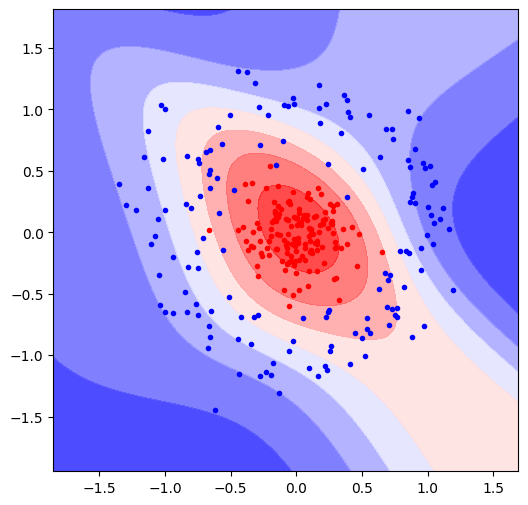

In [149]:
h = .02
x1_min, x1_max = X[:, 0].min() - .5, X[:, 0].max() + .5
x2_min, x2_max = X[:, 1].min() - .5, X[:, 1].max() + .5
x11, x22 = np.meshgrid(np.arange(x1_min, x1_max, h),
    np.arange(x2_min, x2_max, h))
X_disp = np.c_[x11.ravel(), x22.ravel()]
n_disp = X_disp.shape[0]
Z = []
for u in range(mlp.archi[0]):
    mlp.net[0][u].data = X_disp[:,u]
for i in range(n_disp):
    Z.append(mlp.predict(i))
for u in range(mlp.archi[0]):
    mlp.net[0][u].data = X[:,u]
Z = np.array(Z)
Z = Z.reshape(x11.shape)
plt.figure(2,figsize=[6,6])
plt.plot(X[:,0][np.where(y==1)],X[:,1][np.where(y==1)],'.r')
plt.plot(X[:,0][np.where(y==0)],X[:,1][np.where(y==0)],'.b')
plt.contourf(x11, x22, Z, cmap=plt.cm.bwr, alpha=.8)

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0;"> 

# To Conclude 

Finally, this demonstrates that the use of multilayer perceptron (MLP) models makes it possible to solve problems that are initially not linearly separable.    
With gradient-descent optimization and backpropagation, we saw that we are able to minimize the loss function and to learn efficiently the relation between the features and the labels.  
Some points are misclassified, the slight overlap between the classes makes perfect separation impossible without risking overfitting.